In [1]:
%matplotlib inline
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import seaborn as snb

from scipy.stats import wishart
from scipy.stats import multivariate_normal as mvn
from scipy.special import gammaln

from PIL import Image
from exercise10 import Grid2D
from exercise10 import VariationalGMM
from exercise10 import plot_std_dev_contour
from exercise10 import PCA_dim_reduction

# plotting and style stuff
snb.set_style('darkgrid')
colors = snb.color_palette()
snb.set_theme(font_scale=1.1)

# we want to use 64 bit floating precision
import jax
jax.config.update("jax_enable_x64", True)


# 02477 Bayesian Machine Learning - Exercise 10

The purpose of this exercise is to become familiar with variational inference and the coordinate ascent variational inference (CAVI) algorithm in particular. First, we will study CAVI in the context of a simple model, where we will derive all the steps in the algorithm explicitly. Next, we will study Bayesian inference for the Gaussian Mixture model using variational inference and here we will focus more on the application. Finally, you will also become familiar with the Dirichlet and Wishart distributions. 

**Content**

- Part 1: The coordinate ascent variational inference algorithm
- Part 2: Bayesian Gaussian Mixture Model
- Part 3: Variational inference for the Gaussian mixture model
- Part 4: Analyzing a toy data set



**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

**Note**: For this exericise, you will need the python module called `PIL`.

## Part 1:  The coordinate ascent variational inference algorithm

Most models of practical interest leads to intractable posterior distributions, and therefore, we often need to resort to approximations. This week we will study the framework of **variational inference** as an alternative to MCMC methods. The goal of variational inference is to minimize the discrepancy between an approximation $q \in \mathcal{Q}$ and a target distribution of interest $p$, where the discrepancy is measured using a **divergence**. In this course, we will focus on the Kullback-Leibler (KL) divergence, such that
$$\begin{align*}
q^* = \arg\min\limits_{q \in \mathcal{Q}} \text{KL}[q||p],
\end{align*}$$
where $q^* \in \mathcal{Q}$ is the **optimal approximation** within a given **variational family** $\mathcal{Q}$ and $\text{KL}[q||p]$ is the KL-divergence between $q$ and $p$. We optimize over the set of distributions in the variational family and hence, the size of the variational family controls the quality of the approximation. Since probability distributions are functions, we optimize over a function space, which is why this framework is called **variational** inference.

To study variational inference, we will first use it to approximate the posterior distribution of a simple toy model.  Consider a dataset given by $\mathcal{D} = \left\lbrace x_1, x_2, \dots, x_N\right\rbrace$, where $x_n \in \mathbb{R}$. We assume a Gaussian likelihood for the data, i.e.
$$\begin{align*}
p(\mathcal{D}|\mu, \tau) = \prod_{n=1}^N \mathcal{N}(x_n|\mu, \tau^{-1}).
\end{align*}$$

This is equivalent to the likelihood for a linear regression model that only contains an intercept-term, i.e. $\mu \in \mathbb{R}$. Our goal is to estimate the posterior distribution for both the mean $\mu \in \mathbb{R}$ and the precision $\tau > 0$. First, we impose prior distributions over $\mu$ and $\tau$:
$$\begin{align*}
p(\mu, \tau) &= p(\mu|\tau)p(\tau) = \mathcal{N}(\mu|\mu_0, (\lambda_0\tau)^{-1})\text{Gamma}(\tau|a_0, b_0),
\end{align*}$$

where $\mu_0 \in \mathbb{R}$ and $\lambda_0, a_0, b_0 > 0$ are fixed hyperparameters and 
$$\begin{align*}
\text{Gamma}(\tau|a_0, b_0) = \frac{1}{\Gamma(a_0)}b_0^{a_0} \tau^{a_0 - 1}\exp(-b_0 \tau).
\end{align*}$$
 
 Gaussian priors are common for **location** parameters, and Gamma priors are often used for **precision parameters**.

Let's generate a synthetic dataset and visualize the exact posterior, $p(\mu, \tau|\mathcal{D})$. To do that, we will re-use the `Grid2D`-class from week 2.

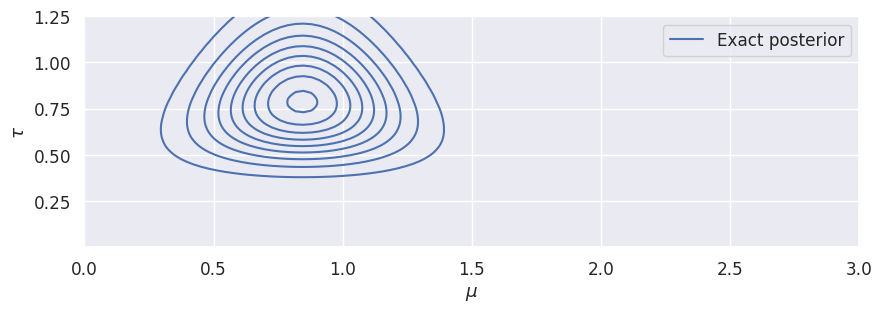

In [2]:
# implement log PDFs for Gaussian and gamma distributions
log_npdf = lambda x, m, v: -0.5*jnp.log(2*jnp.pi*v) - 0.5*(x-m)**2/v
log_gamma = lambda x, a0, b0: -gammaln(a0) + a0*jnp.log(b0) + (a0-1)*jnp.log(x) - b0 *x

# set seed
key = random.PRNGKey(1)

# create synthetic data set
N = 20
x = 1 + jnp.sqrt(0.5*jnp.pi)*random.normal(key, shape=(N,))

# specify hyperparameters of the model
lambda0 = 1.
mu0 = -1.
a0 = 1.
b0 = 1.

# implement exact posterior up to a constant (i.e. the joint distribution)
def exact_posterior(mu, tau):
    """ evaluate and  returns the exact posterior distribution p(mu, tau|D) up to a constant """
    log_lik = log_npdf(x, mu, 1/tau)
    log_prior = log_gamma(tau, a0, b0) + log_npdf(mu, mu0, 1./(lambda0*tau))
    return log_lik.sum(axis=-1)  + log_prior.sum(axis=-1)

# define grid for plotting
mus = jnp.linspace(0, 3, 100)
taus = jnp.linspace(1e-7, 1.25, 101)
exact_posterior_grid = Grid2D(mus, taus, exact_posterior, name='Exact posterior')

# visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
exact_posterior_grid.plot_contours(ax, f=jnp.exp)
ax.legend();


This simple model is a **conjugate model** and hence, we can derive the exact posterior distribution analytically.  However, to become familiar with variational inference, we will approximate the posterior distribution $p(\mu, \tau|\mathcal{D}) \approx q(\mu, \tau)$ using a variational approximation $q(\mu, \tau)$. Specially, we will assume a **factorized** variational family satisfying:
$$\begin{align*}
q(\mu, \tau) = q(\mu)q(\tau).
\end{align*}$$
That is, we choose $\mathcal{Q}$ to be the set of all distributions $q(\mu, \tau)$, where $\mu$ and $\tau$ are **independent**. However, we do **not** assume anything about the shapes or functional forms of $q(\mu)$ or $q(\tau)$. 

We will use the **coordinate ascent variational inference** (CAVI) algorithm to compute the optimal factors $q(\mu)$ and $q(\tau)$, which states that:
$$\begin{align*}
\ln q^*(\mu) &= \mathbb{E}_{q(\tau)} \left[\ln p(\mathcal{D}, \mu, \tau)\right] + \text{constant}\\
\ln q^*(\tau) &= \mathbb{E}_{q(\mu)} \left[\ln p(\mathcal{D}, \mu, \tau)\right] + \text{constant},
\end{align*}$$

where $p(\mathcal{D}, \mu, \tau)$ is the joint distribution for the model. Before computing the expectations above, we will prepare the expression for the joint distribution,  which is the central object when working with variational inference.


**Task 1.1**: **(Optional exercise!)** Show that the logarithm of the joint distribution is given by
$$\begin{align*}
\ln p(\mathcal{D}, \mu, \tau) = \left[a_0 + \frac{N+1}{2} - 1 \right]\ln \tau  -  \left[b_0 +\frac{ N\bar{x^2}}{2} -  \mu (N\bar{x} + \lambda_0 \mu_0) + \frac12 \mu^2  (N + \lambda_0)-  \frac{\lambda_0 }{2}\mu_0^2\right]\tau + K,
\end{align*}$$
where $K$ is an additive constant independent of $\mu, \tau$ and we have defined $N\bar{x} = \sum_{n=1}^N x_i$, and $N\bar{x^2} = \sum_{n=1}^N x^2_i$ to simplify the expressions.

*Hints*: 
- *This is an **optional** exercise designed to practice the process of deriving and simplifying the log joint distribution. However, due to the amount of algebraic manipulations needed, it can be time consuming. Therefore, you can consider skipping it initially and then come back to it if you finish early.*
- *If you decide to skip the task completely, then at least think about how you would solve it and consider checking your understanding with one of the TAs.*



**Task 1.2**: Show that $\ln q^*(\mu) =   \mu (N\bar{x} + \lambda_0 \mu_0)\mathbb{E}_{q(\tau)} \left[\tau \right] - \frac12 \mu^2  (N + \lambda_0)\mathbb{E}_{q(\tau)} \left[\tau \right]+\text{const}$

*Hints: Start with the definition for $\ln q^*(\mu)$. Insert the expression for the log joint distributions and absorb all terms independent of $\mu$ into the additive constant.*






**Task 1.3**: Argue that $q^*(\mu)$ **must** be a Gaussian distribution and identify its mean $m$ and variance $v$ such that $q^*(\mu) = \mathcal{N}(\mu| m, v)$.



**Task 1.4**: Show that $\ln q^*(\tau)$ has the functional form of a Gamma distribution, i.e. $q^*(\tau) = \text{Gamma}(\tau|a,b)$, and identify the parameters $a,b$.

*Hint: The functional form of a Gamma-distribution is $\ln \text{Gamma}(\tau|a,b) = (a-1)\log(\tau)-b\tau + K$.*



We have now shown that

$$\begin{align*}
q^*(\mu) &= \mathcal{N}(\mu|m, v)\\
q^*(\tau) &= \text{Gamma}(\tau|a,b),
\end{align*}$$

where we refer to $m, v, a, b$ as **variational parameters**.

We can now compute the optimal parameters for $m, v, a, b$ using the following steps:
- Initialize $q(\mu)$ and $q(\tau)$ by initializing $m, v, a, b$
- Do until convergence or maximum number of iterations

    - Update $q^*(\mu)$ by computing $m, v$

    - Update $q^*(\tau)$ by computing $a, b$


**Task 1.5**: Complete the implementation of the function `fit_approx` in the class `VariationalApproximation` below.

*Hints: For $\tau \sim \text{Gamma}(\tau|a,b)$, the expected value is $\mathbb{E}\left[\tau\right] = \frac{a}{b}$*.


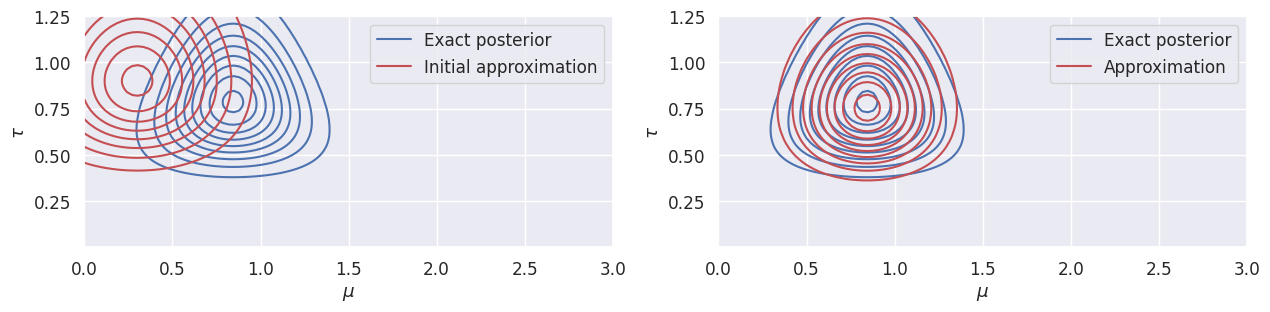

In [3]:
class VariationalApproximation(object):

    def __init__(self, x, mu0=0, lambda0=0, a0=1, b0=1):
        # store data & hyperparameters
        self.x = x
        self.N = len(x)
        self.mu0 = mu0
        self.lambda0 = lambda0
        self.a0 = a0
        self.b0 = b0

    def initialize(self, m, v, a, b):
        self.m = m
        self.v = v
        self.a = a
        self.b = b
        return self

    def fit_approx(self, num_iterations):
        """ Computes the optimal values for variational parameters (m, v, a,b) using CAVI by iteratively updating the components q(mu) = N(mu|m, v) and q(tau) = Gamma(tau|a,b) """

        # precompute 
        xbar = jnp.mean(self.x)
        x2bar = jnp.mean(self.x**2)
        Nxbar = N * xbar
        Nxbarl0mu0 = Nxbar + self.lambda0 * self.mu0
        Npl0 = self.N + self.lambda0
        k = self.lambda0 * self.mu0 / Npl0
        k3 = self.lambda0 / 2  * self.mu0**2 + self.N * x2bar  / 2 + self.b0

        # initialize parameters
        m, v = self.m, self.v
        a, b = self.a, self.b
        a = self.a0 + (self.N + 1) / 2

        for itt in range(num_iterations):

            ##############################################
            # Your solution goes here
            ##############################################
            Eqtau = a / b
            v = 1 / (Npl0 * Eqtau)
            m = Nxbar / Npl0 + k

            Emusq = m**2 + v
            b = Emusq * 0.5 * Npl0 - m * Nxbarl0mu0 + k3
            ##############################################
            # End of solution
            ##############################################

        # sanity check and store optimal variational parameters
        assert v > 0, f"The parameter v must be positive scalar, but the actual value for v was {v:4.3f}. Check your implementation."
        assert a > 0, f"The parameter a must be positive scalar, but the actual value for a was {a:4.3f}. Check your implementation."
        assert b > 0, f"The parameter b must be positive scalar, but the actual value for b was {b:4.3f}. Check your implementation."
        self.a, self.b = a, b
        self.m, self.v = m, v
        return self
        
        
    def pdf(self, mu, tau):
        return log_npdf(mu, self.m, self.v).sum(axis=2) + log_gamma(tau, self.a, self.b).sum(axis=2)
    
# sanity check of results
approx = VariationalApproximation(jnp.array([-1, 1]), mu0, lambda0, a0, b0).initialize(0, 1, 1, 1).fit_approx(100)
assert jnp.allclose(jnp.array([approx.m, approx.v, approx.a, approx.b]), jnp.array([-0.33333333,  0.38888889,  2.5       ,  2.91666667])), 'Expected m, v, a, b. Please check your implementation.'

# initialize approximation
approx = VariationalApproximation(x, mu0, lambda0, a0, b0)
approx.initialize(m=0.3, v=0.1, a=10, b=10)
init_approx_grid = Grid2D(mus, taus, approx.pdf, name='Initial approximation')

# optimize approximation
approx.fit_approx(num_iterations=100)
approx_grid = Grid2D(mus, taus, approx.pdf, name='Approximation')

# visualize
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
exact_posterior_grid.plot_contours(ax[0], f=jnp.exp)
exact_posterior_grid.plot_contours(ax[1], f=jnp.exp)
init_approx_grid.plot_contours(ax[0], f=jnp.exp, color='r')
approx_grid.plot_contours(ax[1], f=jnp.exp, color='r')
ax[0].legend()
ax[1].legend();


If everything was implemented correctly, you should see a plot of the approximate posterior before (left panel) and after (right panel) the optimization process.

**Task 1.6**: What is the approximate marginal distribution of $q(\mu)$ and $q(\tau)$?



## Part 2:  Bayesian Gaussian Mixture Model

**The Gaussian mixture model** is very common in machine learning and statistics with a multitude of applications in clustering, density estimation, and outlier detection. It is also often used a building blocks in more complicated models.

The Gaussian mixture model (GMM) for $D$-dimensional data is a weighted mixture of $K$ Gaussians:

$$\begin{align*}
p(\mathbf{x}_n|\pi, \mathbf{m}, \Lambda) = \sum_{k=1}^K \pi_k N(\mathbf{x}_n|\mathbf{m}_k, \Lambda_k^{-1}), \tag{1}
\end{align*}
$$

where $\mathbf{m}_k \in \mathbb{D}^D$ and $\Lambda_k \in \mathbb{R}^{D \times D}$ are the mean vector and precision matrix for the $k$'th component. The parameters $\pi_k \in [0, 1]$ for $k = 1, .., K$ are the **mixing weights** and satisfy $\sum_{k=1}^K \pi_k = 1$. Intuitively, $\pi_k$ represents the fraction of samples belonging to the $k$'th component.

**The GMM as a latent variable model**

The GMM can also be formulated as a latent variable model with latent variables $z_n$ such that

$$\begin{align*}
p(\mathbf{x}_n|z_n, m, \Lambda) = \prod_{k=1}^K N(\mathbf{x}_n|\mathbf{m}_k, \Lambda_k^{-1})^{z_{nk}} \tag{2}
\end{align*}
$$

where $z_n$ is a $K$-dimensional one-hot encoded binary vector indicating the component index for the $n$'th observation. This implies
$$\begin{align*}
p(\mathbf{x}_n|z_n=j, m, \Lambda) =  N(\mathbf{x}_n|m_j, \Lambda_j^{-1})
\end{align*}
$$
Note that we often abuse the notation and write e.g. $z_n = 3$ as a shorthand notation for $z_n = \begin{bmatrix} 0 & 0 & 1 & 0 \dots 0 \end{bmatrix}$ and so on.
The distribution of the latent variables is given by

$$\begin{align*}
p(z_n|\pi) = \text{Categorial}(z_n|\pi) = \prod_{k=1}^K \pi_k^{z_{nk}} \tag{3},
\end{align*}
$$

where $\pi_k$ is the proportion of sample from the $k$'th component, i.e. $p(z_n=j|\pi) = \pi_j$. The variable $z_n$ is called a **latent variable** because we can't observe it, we can only observe $\mathbf{x}_n$. 

We can derive the marginalized formulation in eq. (1) from the latent variable formulation in eq. (2)-(3) by applying to sum rule to marginalize over the latent variable $z_n$, i.e. $p(\mathbf{x}_n) = \sum_{k} p(\mathbf{x}_n|z_n=k)p(z_n=k)$.





**Maximum likelihood**

The classic way to estimate the model parameters for GMMs ($m_k, \Lambda_k, \pi_k$ for $k = 1, .., K$) is through maximum likelihood estimation via the Expectation-Maximimization (EM) algorithm (not part of the curriculum of this course). However, the maximum likelihood solution is not well-posed and can suffer from singularities when a component "collapses" on a single data point. This causes the variance component for the collapsing component to go to zero and eventually the algorithm will crash.

**Imposing priors**

We can avoid these issues by using Bayesian inference to estimate the parameters. As usual, we impose prior distributions on the parameters: $m_k$, $\Lambda_k$, and $\pi_k$:

$$\begin{align*}
\pi &\sim \text{Dirichlet}(\alpha_0)\\
%
\Lambda_k &\sim \text{Wishart}(W_0, \nu_0)\\
%
\mu_k|\Lambda_k &\sim \text{Normal}(m_0, \left(\beta_0\Lambda_k\right)^{-1})\\
%
z_n|\pi &\sim \text{Categorical}(\pi)\\
%
x_n|\mu, \Lambda, z_n &\sim \text{Normal}(\mu_{z_n}, \Lambda_{z_n}^{-1}),
\end{align*}
$$

where we consider all parameters with subscript '0' as hyperparameters. 


**Task 2.1**: What is the sample space for each of the distributions above?





**Generative story**

We can interret and visualize the assumptions of the model by considering the generative story of the model. Assume the number of observations $N$ and the number of components $K$ are fixed. By using Bayesian GMM to model a data set, we assume that the data set has been generated in the following way:

1. Nature samples the mixing weights $\pi\sim \text{Dirichlet}(\alpha_0)$


2. Nature samples a precision matrix $\Lambda_k\sim \text{Wishart}(W_0, \nu_0)$ for each component $k = 1, ..., K$


3. Nature then samples a mean $m_k|\Lambda_k\sim \text{Normal}(m_0, \left(\beta_0\Lambda_k\right)^{-1})$ for each component $k=1, ..., K$ conditioned on $\Lambda_k$


4. For each data point, nature samples a component index $z_n|\pi \sim \text{Categorical}(\pi)$


5. For each data point, nature samples an observation from the relevant cluster distribution $x_n|\mu, \Lambda, z_n \sim \text{Normal}(\mu_{z_n}, \Lambda_{z_n}^{-1})$


We can use **ancestral sampling** to generate synthetic data sets from this model

**Task 2.2**: Complete the implementation of ancestral sampling below.

*Hints:* 
- *The functions `random.dirichlet`, `random.choice`, and `scipy.stats.wishart.rvs` will be handy. Note that the Wishart distribution is not supported by JaX, and therefore, we will rely on the `scipy.stats` module instead.*
- *Recall: everytime we want to generate a random number in JaX, we need to explicitly provide a `key` to specify the state of the random number generator. The code below prepares a unique key for each sampling step. That is, `key_pi` is intended to be used when sampling $\pi$,  `key_m` is an array of keys intended to be used when sampling each of the $m_k$ and so on and so forth. See https://docs.jax.dev/en/latest/random-numbers.html for more info.*


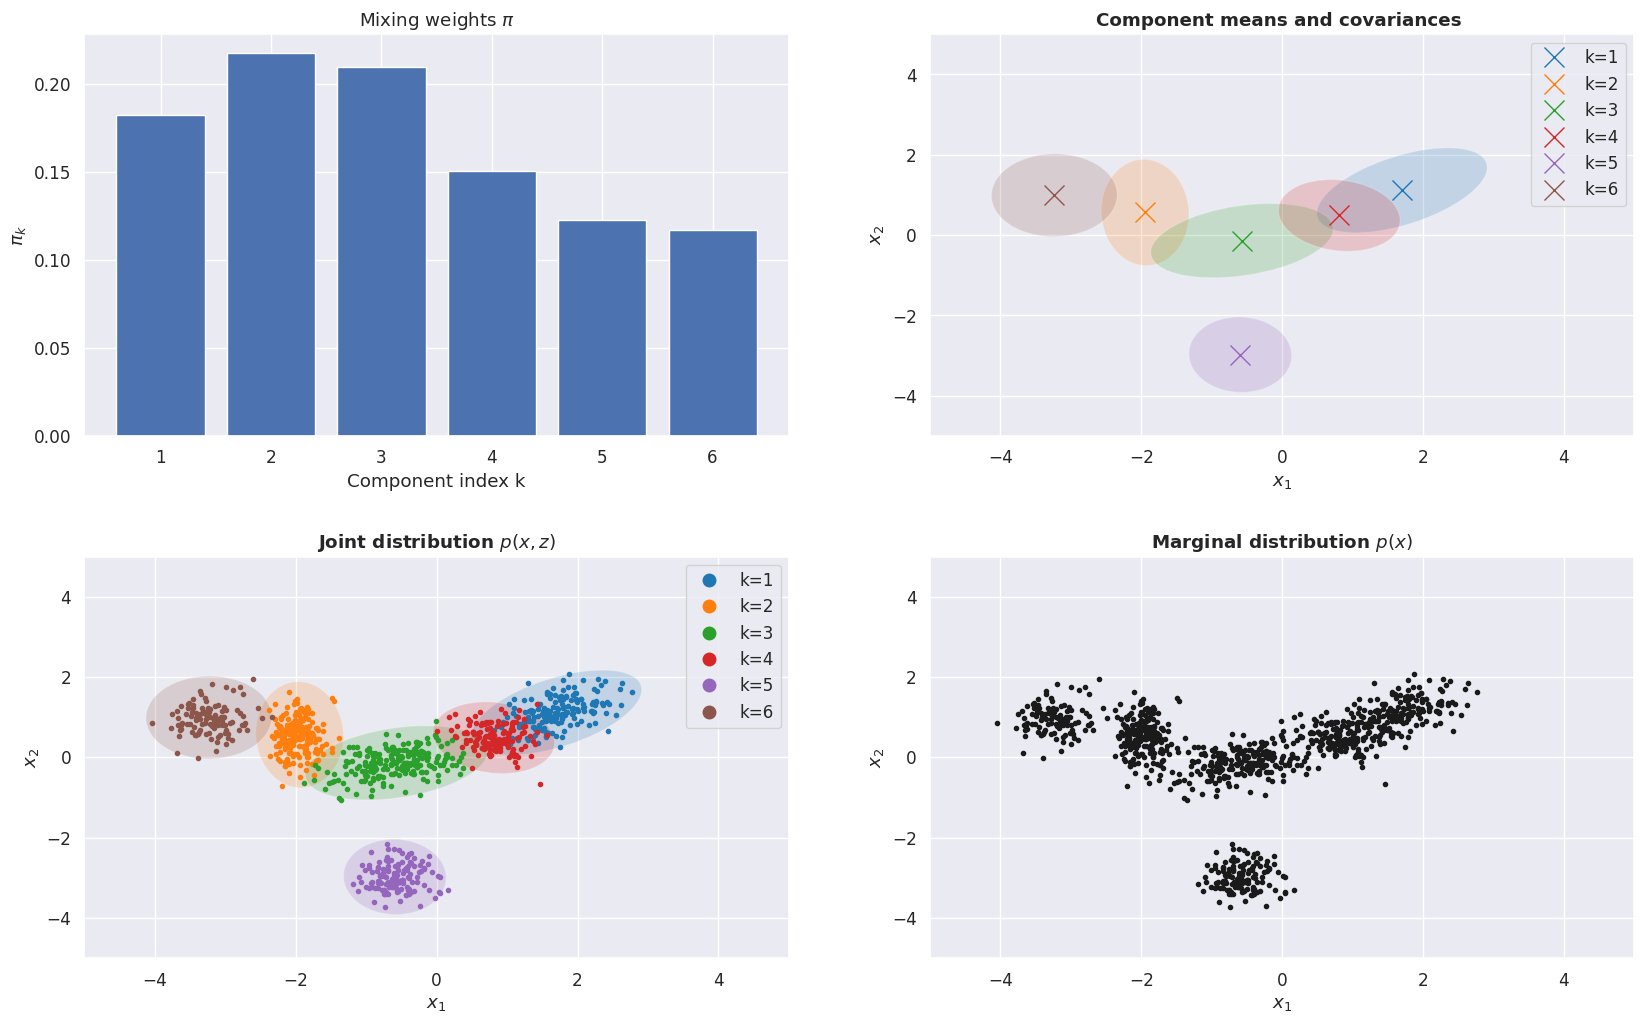

In [4]:
# number of components K,  dimension D, and number of observations N
K = 6
D = 2
N = 1000

from scipy.stats import wishart as wis

# prepare keys for random number generations
key = random.PRNGKey(124)
key_pi, key_m, key_z, key_x = random.split(key, num=4)
key_m = random.split(key_m, num=K) # split into array of K keys, one for each m_k
key_x = random.split(key_x, num=N) # split into array of N keys, one for each x_n

# hyperparameter for the Dirichlet distribution
alpha0 = 2.*jnp.ones(K)

# hyperparameters for the components
m0 = jnp.zeros(D)
W0 = jnp.identity(D)
nu0 = 10
beta0 = 0.02

# Step 1: sample mixing weights (jnp array with shape (K,))
pi = random.dirichlet(key = key_pi, alpha = alpha0)

# Step 2: sample prior precision matrix for each component (jnp array with shape (K, D, D))
Lambda_k = wis.rvs(df = nu0, scale = W0, size = (K))

# Step 3: sample prior mean vector for each component
Sk = []
mk = []
for k in range(K):
    Sk.append(jnp.linalg.inv(Lambda_k[k]))
    mk.append(random.multivariate_normal(key_m[k], m0, Sk[k]/beta0))
    
# Step 4: sample latent variable for each observation (jnp array with shape (N, ))
z = random.choice(a = jnp.arange(K), p = pi, shape = (N,), key = key_z)

# Step 5: sample observations for all n (jnp array with shape (N, D))
X = []
for n in range(N):
    X.append( random.multivariate_normal(key = key_x[n], mean = mk[z[n]], cov = Sk[z[n]] ))
X = jnp.stack(X)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# plot mixing weights
axes[0,0].bar(jnp.arange(1,K+1), pi)
axes[0,0].set(xlabel='Component index k', ylabel = '$\\pi_k$', xticks=jnp.arange(1, K+1))
axes[0,0].set_title('Mixing weights $\\pi$')

# plot component mean and covariances
for k in range(K):
    axes[0,1].plot(mk[k][0], mk[k][1], 'x', color=colors[k], markersize=15, label='k=%d' % (k+1)) 
    plot_std_dev_contour(axes[0, 1], mk[k], Sk[k], facecolor=colors[k], alpha=0.2)
    plot_std_dev_contour(axes[1, 0], mk[k], Sk[k], facecolor=colors[k], alpha=0.2)
    axes[1,0].plot(X[z==k, 0], X[z==k, 1], '.', color=colors[k], label='k=%d' % (k+1))

axes[0,1].set_title('Component means and covariances ', fontweight='bold')
axes[0,1].legend()
axes[1,0].set_title('Joint distribution $p(x, z)$', fontweight='bold');
axes[1,0].legend(markerscale=3)

# plot observations
axes[1,1].plot(X[:, 0], X[:, 1], '.', color='k')
axes[1,1].set_title('Marginal distribution $p(x)$', fontweight='bold');
    
# add labels etc
for a in [1, 2, 3]:
    axes.flat[a].set(xlim = (-5, 5), ylim=(-5, 5), xlabel='$x_1$', ylabel='$x_2$')

fig.subplots_adjust(hspace=0.3)

**Task 2.3**: Why is the Dirichlet distribution sometimes called a "distribution over distributions"?  [**Discussion question**]

It samples probablity of belonging to a certain distribution


**Task 2.4**: How does the hyperparameter $\alpha_0$ affect the generated samples? Explore the generated datasets for different values of $\alpha_0$, e.g. $\alpha_0 = 0.2 \cdot \mathbf{1}$, $\alpha_0 = 1 \cdot \mathbf{1}$, and $\alpha_0 = 10 \cdot \mathbf{1}$, where $\mathbf{1}$ is a $K$-dimensional vector of ones. Inspect the results for a few different random seeds. [**Discussion question**]


**Task 2.5**: Relate the panels in the figure above to the "generative story" explained above. [**Discussion question**]

**Task 2.6**: Which hyperparameter do we need to change in order to increase the separation between clusters, i.e. to increase the distance between the means of each cluster? [**Discussion question**]

$b_0$


## Part 3:  Variational inference for the Gaussian mixture model

We are now ready to set-up the variational approximation for the mixture model. The joint distribution of observed data $\mathbf{X}$, latent variable $\mathbf{Z}$ and model parameters $\mu, \Lambda, \pi$ follows from the **product rule**:

$$\begin{align*}
p(X, Z, \mu, \Lambda, \pi) &=\prod_{n=1}^N \prod_{k=1}^K \mathcal{N}(x_n|\mu_k, \Lambda^{-1}_k)^{z_{nk}}\prod_{n=1}^N \text{Cat}(z_n|\pi)\,\text{Dir}(\pi|\alpha) \prod_{k=1}^K p(\mu_k, \Lambda_k),
\end{align*}
$$

where

$$\begin{align*}
p(\mu_k, \Lambda_k) = p(\mu_k|\Lambda_k)p(\Lambda_k) = \mathcal{N}(\mu_k|m_0, \left[\beta_0 \Lambda_k\right]^{-1})\mathcal{W}(\Lambda_k|W_0, \nu_0).
\end{align*}
$$


Our goal is to compute the posterior distribution of the parameters conditioned on the data $X$, i.e. $p(Z, \mu, \Lambda, \pi|X)$. However, computing the exact posterior distribution for this model would require us to sum over all $K^N$ possible configurations of the latent variables $z_n$, which becomes infeasible for even small to moderate sized datasets. Therefore, we have to resort to approximate inference. In this exercise, we will work with **variational approximations**, but one could also implement an MH-sampler or derive a Gibbs sampler for the model.

Informally, we define a collection of tractable distributions $\mathcal{Q}$ and search for the distribution $q \in \mathcal{Q}$ that resembles the true posterior distribution as close as possible as measured by the **Kullback-Leibler (KL) divergence** $\text{KL}[q||p]$. 

For the Baysian GMM, we choose the variational family $\mathcal{Q}$ to be the collection of all distributions with following factorization

$$\begin{align*}
q(Z, \mu, \Lambda, \pi) = q(Z)q(\mu, \Lambda, \pi)
\end{align*}$$

That is, we assume that the latent variables $z_n$ are independent from the rest of variables and then we search for the best matching distribution under this independence assumption. Note that this is the only assumption we need in order to be able to derive a variational approximation for the posterior.

To identify the best matching distribution $q^* \in \mathcal{Q}$, we minimize the KL-divergence between $q \in \mathcal{Q}$ and $p \equiv p(Z, \mu, \Lambda, \pi|X)$

$$\begin{align*}
q^* = \arg\min\limits_{q \in \mathcal{Q}} \text{KL}[q||p]. \tag{4}
\end{align*}$$

As shown in the lecture, the KL-divergence $\text{KL}[q||p]$ can we re-written as


$$
\begin{align*}
\text{KL}[q||p] = \ln p(X) - \mathcal{L}[q] \quad\quad\iff\quad\quad \ln p(X) = \text{KL}[q||p] + \mathcal{L}[q], \tag{5}
\end{align*}
$$

where $p(X)$ is the marginal likelihood and the $\mathcal{L}[q]$ is the **evidence lowerbound (ELBO)** defined as

$$
\begin{align*}
\mathcal{L}[q] = \mathbb{E}_q\left[\ln p(X, Z, \mu, \Lambda, \pi)\right] - \mathbb{E}_q\left[\ln q(Z, \mu, \Lambda, \pi)\right] \tag{6}
\end{align*}
$$


In practice, we optimize the **lower bound** $\mathcal{L}[q]$ rather than the KL divergence

$$\begin{align*}
q^* = \arg\max\limits_{q \in \mathcal{Q}} \mathcal{L}[q]. \tag{7}
\end{align*}$$

Using the CAVI algorithm leads to iterating the following two steps:

$$\begin{align*}
\ln q(Z) &\propto \mathbb{E}_{q(\mu, \Lambda, \pi)}\left[\ln p(X, Z, \mu, \Lambda, \pi)\right] \tag{8}\\
\ln q(\pi, \mu, \Lambda) &\propto \mathbb{E}_{q(Z)}\left[\ln p(X, Z, \mu, \Lambda, \pi)\right]. \tag{9}
\end{align*}$$

We fit the approximation by optimizing the lower bound $\mathcal{L}[q]$. Therefore, we can evaluate and monitor $\mathcal{L}[q]$ using eq. (6) to check when the optimization has converged.

Eq. (8) and (9) above can be reduced to a set of simple update equations as done in Bishop from eq. (10.43) to (10.68). In this course, we won't dive into these specific calculations, instead we will focus on understanding the general methodology. That is, you should be able to understand and explain the ideas behind equations eq. (4)-(9) from a conceptual point of view, but the steps from eq. (8)-(9) to eq. (10) will not be part of the curriculum.

Don't worry if these concepts appear very abstract now, we will see more examples in the following two weeks, but make sure the discuss the key equations with one of the teachers, if you find them confusing.

The optimal variational approximation takes the form

$$\begin{align*}
q(Z, \pi, \mu, \Lambda) = q(Z)q(\pi)q(\mu, \Lambda) = \underbrace{\prod_{n=1}^N \text{Categorial}(z_n|r_n)}_{q(Z)} \underbrace{\text{Dir}(\pi|\alpha)}_{q(\pi)}\underbrace{\prod_{k=1}^K \mathcal{N}\left(\mu_k|m_k, \left[\beta_k\Lambda_k\right]^{-1}\right)\mathcal{W}(\Lambda_k|W_k, \nu_k)}_{q(\mu, \Lambda)} \tag{10}
\end{align*}
$$



The variable $Z$ represents the cluster assignments, and the (approximate) posterior distribution $Q(Z)$ represents the distribution over cluster assignments for each data point after having seen the data. The posterior cluster assignment for the $n$'th datapoint is $q(z_n) = \text{Categorical}(z_n|r_n)$, where $z_n$ is cluster index (and sometimes represented as a one-hot encoded vector) and $r_n$ is a vector probabilities such that probability of the $n$'th data point being in cluster $k$ is $r_{n,k}$. These probabilities are often called ***responsibilities*** as the number $r_{n,k}$ can be interpreted as how much the $k$'th cluster is responsible for explaning the $n$'th data point. 

We often defined the **effective number of data points** in the $k$'th cluster to be

\begin{align*}
N_k = \sum_{n=1}^N r_{n, k} \tag{eq. (10.51) in Bishop}
\end{align*}

The posterior distribution of the mixing weights is $Q(\pi) = \text{Dir}(\pi|\alpha)$, where $\alpha \in \mathbb{R}^D_+$ is as vector of parameters for the Dirichlet distribution, where $a_k = a_0 + N_k$. The posterior mean of the $k$'th mixing weight is therefore

\begin{align*}
\mathbb{E}\left[\pi_k|X\right] = \frac{\alpha_0 + N_k}{K\alpha_0 + N} \tag{eq. (10.69) in Bishop}.
\end{align*}

Note that there is a typo in the corresponding equation in Bishop eq. (10.69). 
The posterior distribution for the $k$'th cluster mean and cluster precision is $q(\mu_k|\Lambda_k) = \mathcal{N}(\mu_k|m_k, \left[\beta_k \Lambda_k\right]^{-1})$ and $q(\Lambda_k) = \mathcal{W}(W_k, \nu_k)$, respectively, where the parameters are given by

\begin{align*}
    \beta_k &= \beta_0 + N_k\\
    m_k &= \frac{1}{\beta_k}(\beta_0 m_0 + N_k \bar{x}_k)\tag{10b}\\
    W_k^{-1} &= W^{-1}_0 + N_k S_k + \frac{\beta_0 N_k}{\beta_0 + N_k} (\bar{x}_k - m_0)(\bar{x}_k-m_0)^T\\
    \nu_k &= N_k + 1
\end{align*}

for 

\begin{align*}
\bar{x}_k &= \frac{1}{N_k} \sum_{n=1}^N r_{n,k} x_n\\
S_k &= \frac{1}{N_k} \sum_{n=1}^N r_{n,k} (x_n - \bar{x}_n)(x_n - \bar{x}_n)^T
\end{align*}


**Task 3.1**: Use eq. (5) to explain why $\mathcal{L}[q]$ is a lower bound on $\ln p(X)$. [**Discussion question**]



**Task 3.2**: Use eq. (5) to explain why maximizing the lower bound $\mathcal{L}[q]$ is equivalent to minimizing the KL-divergence wrt. $q$ [**Discussion question**]


**Task 3.3**: Show that the posterior mean $m_k$ for each cluster  is a convex combination of the prior mean and the weighed average of the data points $\bar{x}_k$. That is, show that there exist some value $\rho \in \left[0, 1\right]$ such that

\begin{align*}
    m_k = (1-\rho)m_0 + \rho \bar{x}_k
\end{align*}

*Hints*: 
- Argue that $\rho = \frac{N_k}{\beta_k} \in \left[0, 1\right]$ and $\frac{\beta_0}{\beta_k} = 1 - \rho$.
- If you don't know how to get started here, do not hesitate to ask for help :-)

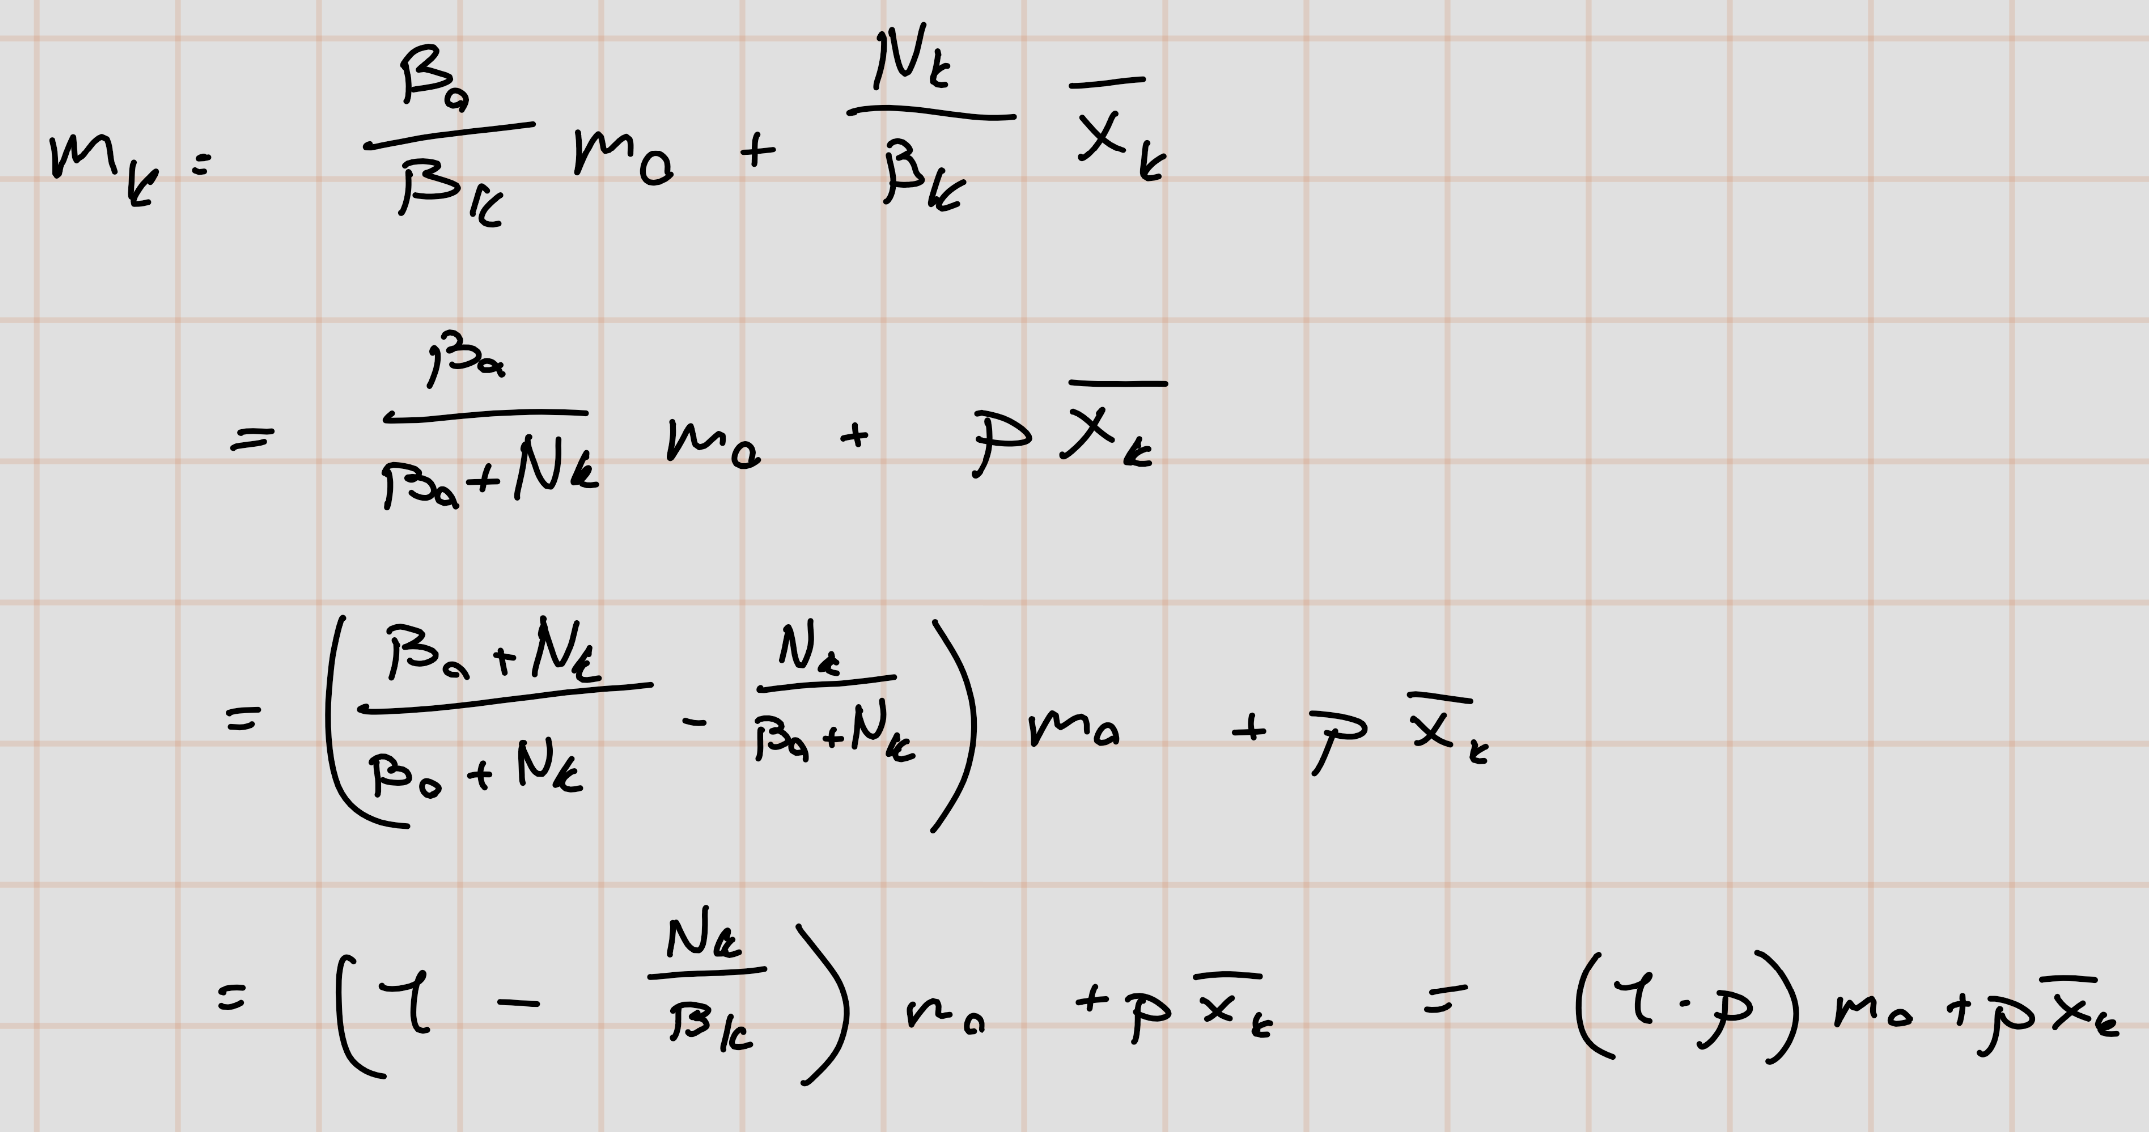

**Task 3.4**: **Optional**  Show that the posterior mean for cluster $k$ converges to the prior mean when $\beta_0 \rightarrow \infty$ using eq. (10.b)

*Hints*
- What happens to $\beta_k$ when $\beta_0 \rightarrow \infty$?
- If you don't know how to get started here, do not hesitate to ask for help :-)

mk goes to m0
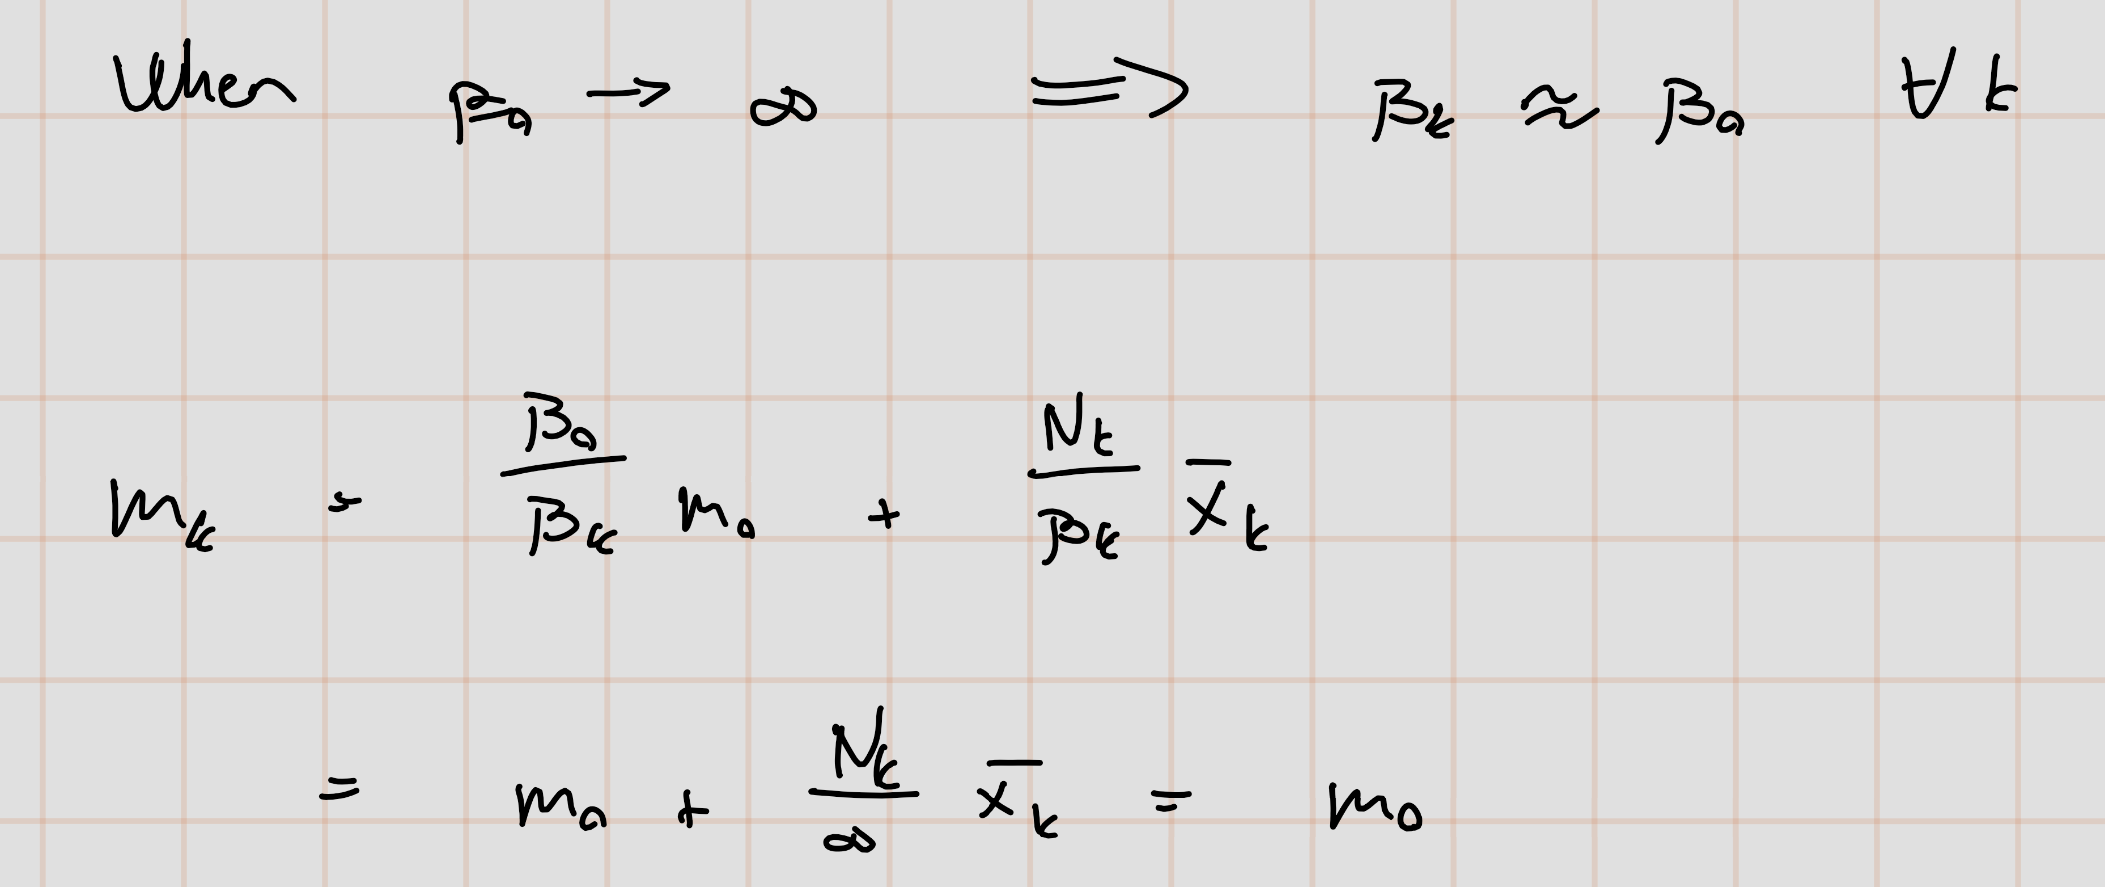

## Part 4:  Analyzing a toy data set

The class `VariationalGMM` in the module `exercise10.py` provides a basic implementation of variational approximation of the GMM described above.
First, we will use the Variational GMM algorithm to analyze a simple toy dataset:

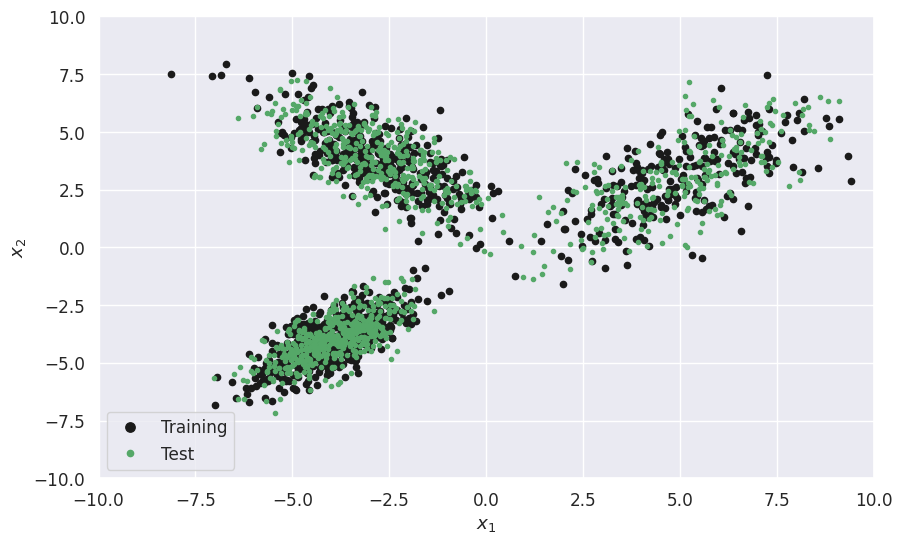

In [5]:
# load data
data = jnp.load('./exercise10_toydata.npz')
X = data['X']
N = len(X)

# split data in training/test
key = random.PRNGKey(123)
Ntrain = int(0.5*N)
Ntest = N - Ntrain
test_idx = random.choice(key, jnp.arange(N), replace=False, shape=(Ntest, ))
train_idx = jnp.setdiff1d(jnp.arange(N), test_idx)
Xtrain, Xtest = X[train_idx], X[test_idx]

# plot data
def plot_data(ax=None, train=True, test=True, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    if train:
        ax.plot(Xtrain[:, 0], Xtrain[:, 1], 'k.', label='Training', markersize=9)
    if test:
        ax.plot(Xtest[:, 0], Xtest[:, 1], 'g.', label='Test')
    if legend:
        ax.legend(markerscale=1.5)
    ax.set(xlabel='$x_1$', ylabel='$x_2$', xlim=(-10, 10), ylim=(-10, 10))

plot_data()

By visual inspection of the data, there seems to be three clusters. So let's run the variational algorithm for $K = 3$:

Converged in   37 iterations for K =  3 with lowerbound = -4546.178. Time = 1.19
Test LPD for K=3: -4533.747


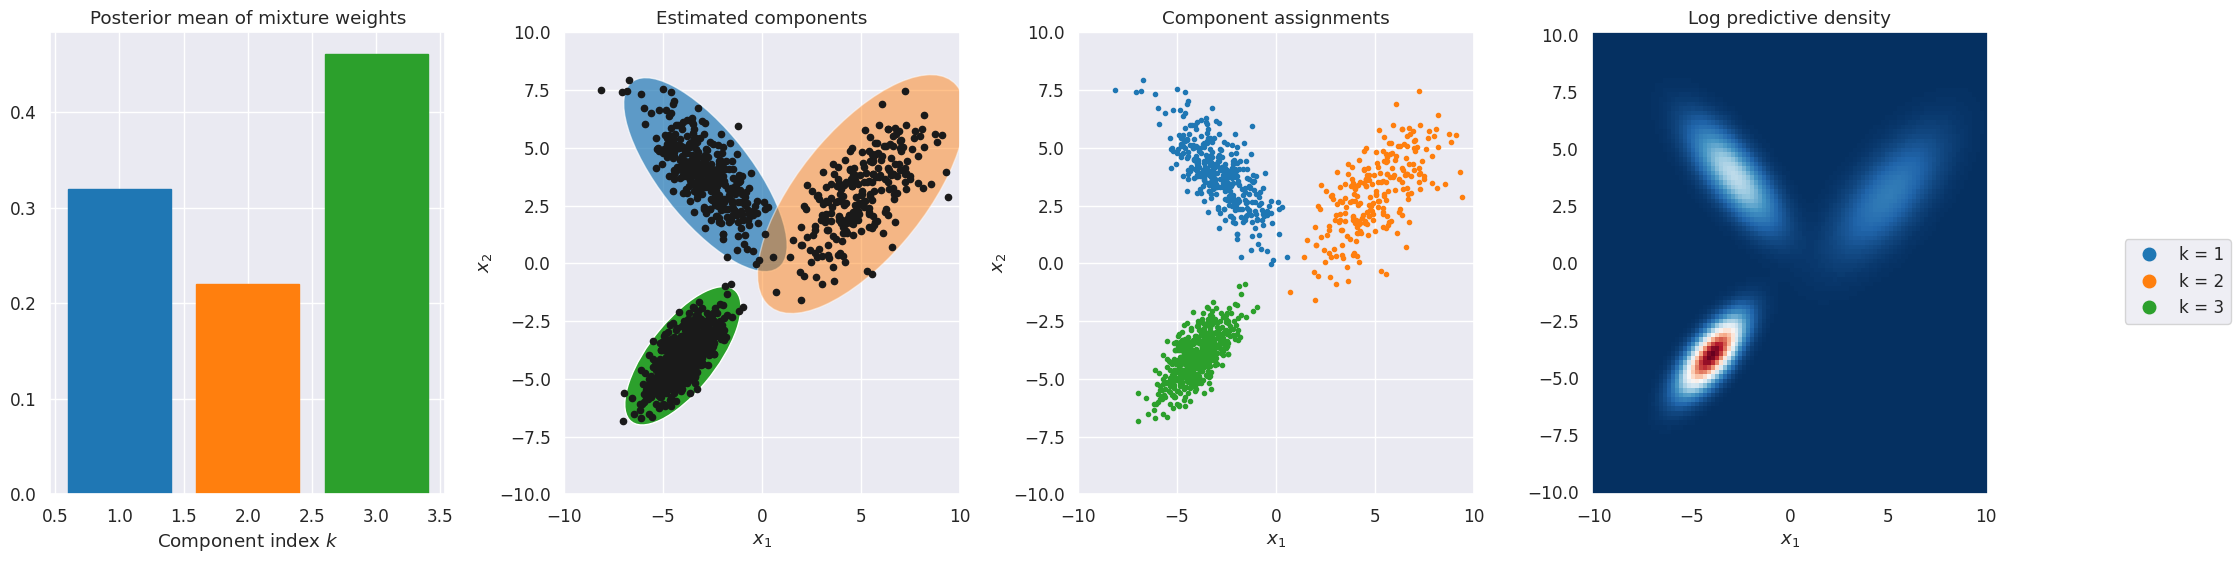

In [15]:
# fit the model with dimension D = 2 and K = 3 number of clusters.
vi = VariationalGMM(D=2, K=3, alpha0=10)   
vi.fit(Xtrain, max_itt=10000, seed=5)

# compute probabilities p(z_n|x_n) (for the training data, we could also have used vi.r instead of ptrain)
ptrain = vi.compute_component_probs(Xtrain)
ztrain = jnp.argmax(ptrain, axis=1)

# prepare grid for log predictive density (lpd)
P = 100
x_grid = jnp.linspace(-10, 10, P)
XX, YY = jnp.meshgrid(x_grid, x_grid)
Xp = jnp.column_stack((XX.ravel(), YY.ravel()))
lpd = vi.evaulate_log_predictive(Xp, pointwise=True).reshape((P, P))

# evaluate log predictive density for test set
test_lpd = vi.evaulate_log_predictive(Xtest)
print(f'Test LPD for K={vi.K}: {test_lpd:4.3f}')

# prep. plot
fig, axes = plt.subplots(1, 4, figsize=(25, 6))
# plot mixing weights
barlist = axes[0].bar(jnp.arange(1, vi.K+1), vi.pi)

for k in range(vi.K):
    barlist[k].set_color(colors[k])
    
# plot data, clusters and assignments
plot_data(ax=axes[1], test=False, legend=False)
handles, labels = [], []
for k in range(vi.K):
    plot_std_dev_contour(axes[1], vi.m[k], vi.S[k], facecolor=colors[k], alpha=float(vi.pi[k]/jnp.max(vi.pi)), label=f'k ={k+1}')
    hk = axes[2].plot(Xtrain[ztrain==k, 0], Xtrain[ztrain==k, 1], '.', color=colors[k])
    handles.append(hk[0])
    labels.append('k = %d' % (k+1))

# plot predictive density
axes[3].pcolormesh(x_grid, x_grid, jnp.exp(lpd), cmap=plt.cm.RdBu_r, shading='auto')

    
# labels, titles etc
axes[0].set(title='Posterior mean of mixture weights', xlabel='Component index $k$');
axes[1].set(title='Estimated components', xlabel='$x_1$', ylabel='$x_2$')
axes[2].set(title='Component assignments', xlim=(-10, 10), ylim=(-10, 10), xlabel='$x_1$', ylabel='$x_2$')
axes[3].set(xlabel='$x_1$', title='Log predictive density')

fig.legend(handles, labels, loc='center right', markerscale=3);
fig.subplots_adjust(hspace=0.3, wspace=0.3)

    

**Task 4.1**: Explain what you see in the three panels. What is the value of the lower bound for $K = 3$? [**Discussion question**]

The value is $-4546$

1st figure is the percentage og points in each cluster

2nd is the normal models 

3rd is the model predictions

4th is the posterior predictive denisity


**Task 4.2**: What happens if you run the analysis with $K = 10$? Explain what you see. What is the value of the lower bound for $K = 10$? [**Discussion question**]

*Notes*
- the algorithm may take a bit longer to run for $K = 10$  
- the plotting code does not work for $K \geq 11$ due to the chosen color scheme

The value of the lower bound goes down (-4672)

It seems to just split up the clusters




**Task 4.3**: In the simulation, we have used a Dirichlet prior with hyperparameter value $\alpha_0 = 10$. What happens of you decrease it to $\alpha_0 = 0.1$? What is the value of the lower bound? [**Discussion question**]

The lower bound goes up



**Task 4.4**: What is the interpretation of the $\alpha_0$ parameter and how does it affect the prior distribution of the mixing weights $\pi$? Use eq. (10.69) in Bishop
 above to explain your reasoning. [**Discussion question**]

Its a shift in probability from just how large a proportion of the points come from a cluster in the data. $\alpha = 1000$ gives pretty much uniform posterior cluster weights



**Task 4.5**: What happens if you run the analysis multiple times with different seeds? Why does the assigned clusters change from run to run, but not the predictive density? [**Discussion question**]

The model is indifferent about which cluster is which, so it just randomly chooses


**Task 4.6**: Only one of the following to questions is meaningful to answer. Which one and why?

- What is the posterior probability of the $7$'th data point belonging to the $2$-nd cluster?
- What is the posterior probability of the $7$'th and $9$'th data points beloging to the same cluster?




* The second one, since it doesn't matter what the "2-nd" cluster is. But it matters if two points are close together

**Model selection**

We can choose an optimal value for $K$ by measuring the log predictive density $p(x^*|\bm{X})$ using eq. (10.80) in Bishop for an independent test/validation set as done below. First, let's repeat and plot the above figure for $K \in \left[1, 2, 3, 4, 5, 10\right]$ for $\alpha_0= 0.1$.

Converged in    1 iterations for K =  1 with lowerbound = -6113.431. Time = 0.57
Converged in   39 iterations for K =  2 with lowerbound = -5112.039. Time = 0.81
Converged in   33 iterations for K =  3 with lowerbound = -4550.666. Time = 0.84
Converged in   90 iterations for K =  4 with lowerbound = -4551.668. Time = 2.91
Converged in   75 iterations for K =  5 with lowerbound = -4552.595. Time = 2.59
Converged in   57 iterations for K = 10 with lowerbound = -4556.680. Time = 3.88


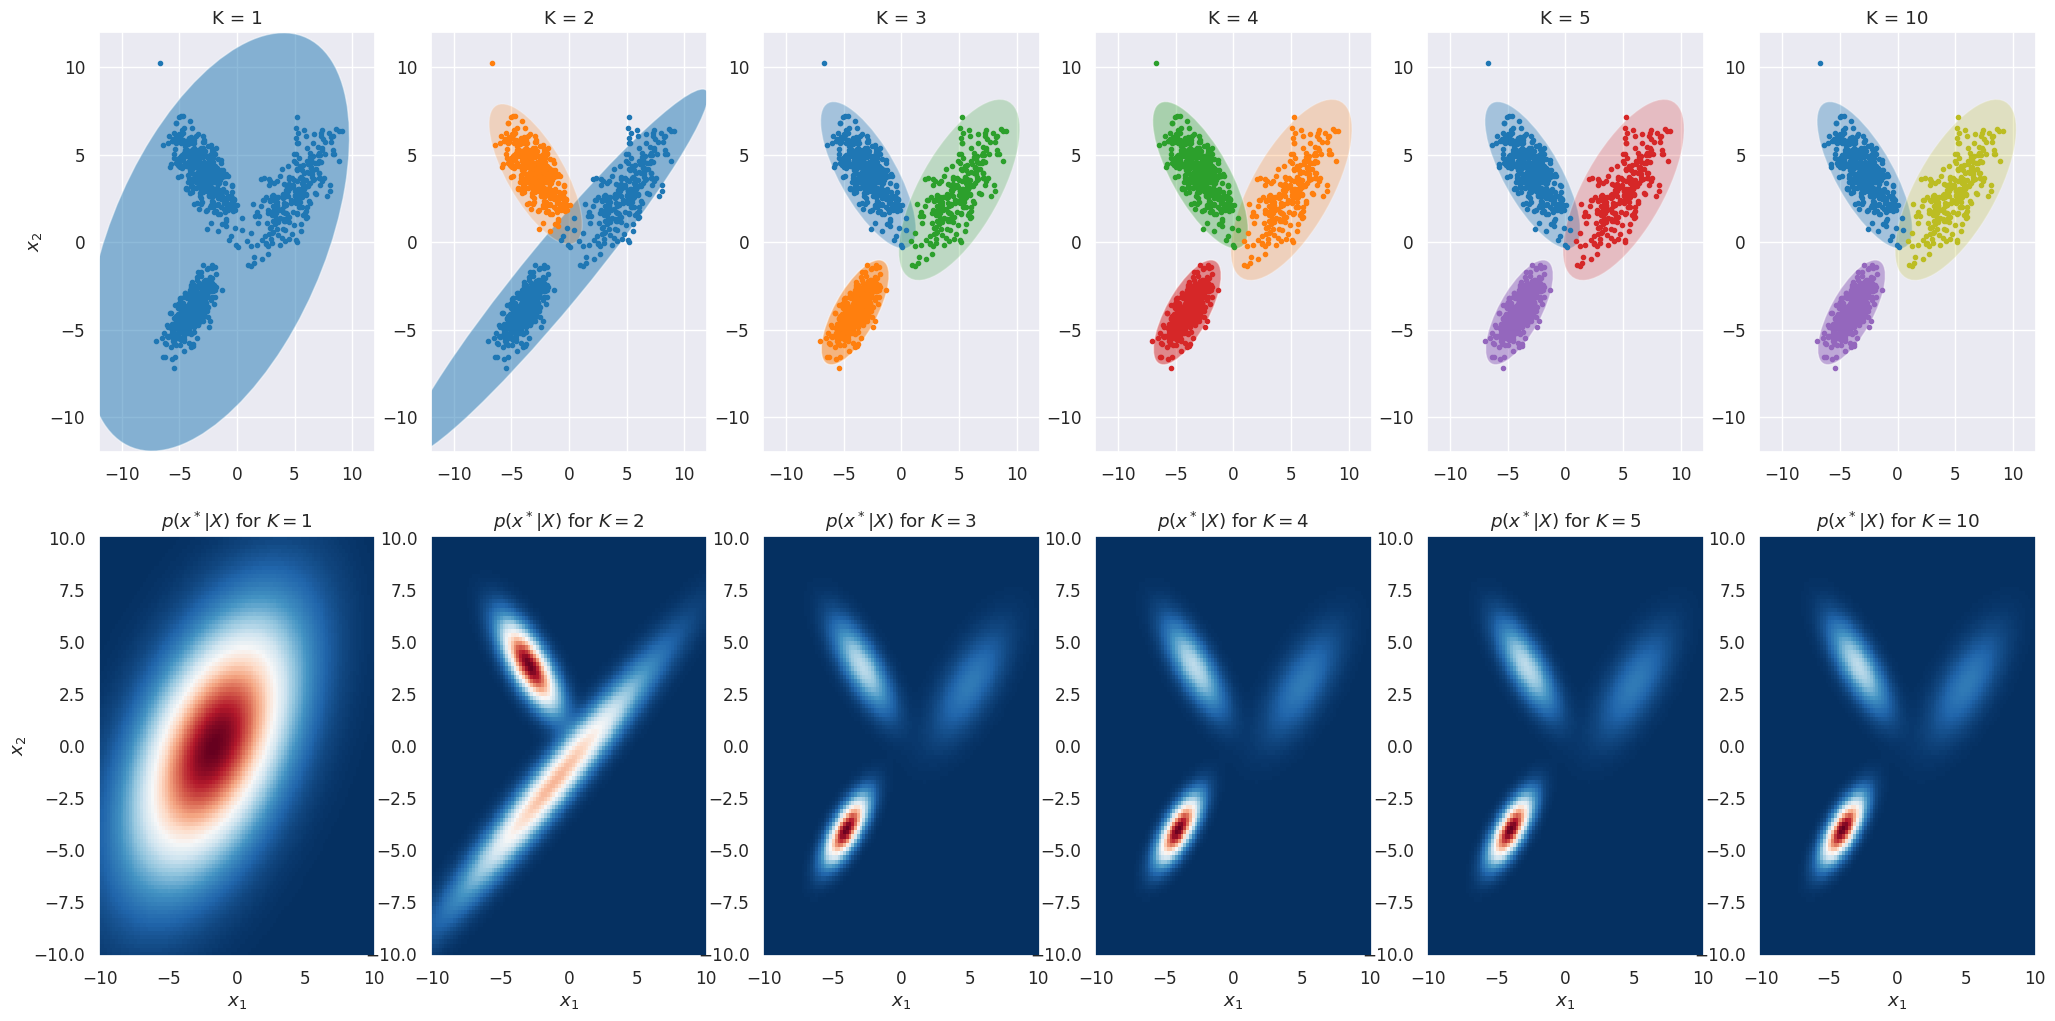

In [47]:
# fit models for K = 1, .., 5, 10
Ks = [1, 2, 3, 4, 5, 10]
fits = [VariationalGMM(D=2, K=K, alpha0=0.1).fit(Xtrain, max_itt=10000) for K in Ks]

# prepare grid
P = 100
x_grid = jnp.linspace(-10, 10, P)
XX, YY = jnp.meshgrid(x_grid, x_grid)
Xp = jnp.column_stack((XX.ravel(), YY.ravel()))
lpds = []
# plot
fig, axes = plt.subplots(2, len(fits), figsize=(25, 12))
for idx_fit, fit in enumerate(fits):
    
    # compute class assignments for test set
    z = jnp.argmax(fit.compute_component_probs(Xtest), axis=1)

    # compute lpd
    lpd = fit.evaulate_log_predictive(Xp, pointwise=True).reshape((P, P))
    lpds.append(fit.evaulate_log_predictive(Xtest))

    # plot
    for k in range(fit.K):
        plot_std_dev_contour(axes[0, idx_fit], fit.m[k], fit.S[k], facecolor=colors[k], alpha=float(0.5*fit.pi[k]/jnp.max(fit.pi)), label=f'k ={k+1}')
        axes[0, idx_fit].plot(Xtest[z==k, 0], Xtest[z==k, 1], '.', color=colors[k])
        axes[0, idx_fit].set(title='K = %d' % fit.K, ylim=(-12, 12), xlim=(-12, 12))
        axes[1, idx_fit].pcolormesh(x_grid, x_grid, jnp.exp(lpd), cmap=plt.cm.RdBu_r, shading='auto')
        axes[1, idx_fit].set(xlabel='$x_1$', title='$p(x^*|X)$ for $K = %d$' % fit.K)
    axes[0, 0].set_ylabel('$x_2$')
    axes[1, 0].set_ylabel('$x_2$')



**Task 4.7**: Compute the average log predictive density for the test for each K and plot it as a function of $K$. What is the optimal number of clusters?

*Hint: use the function `evalulate_log_predictive` from the `VariationalGMM´ object*



(6,)


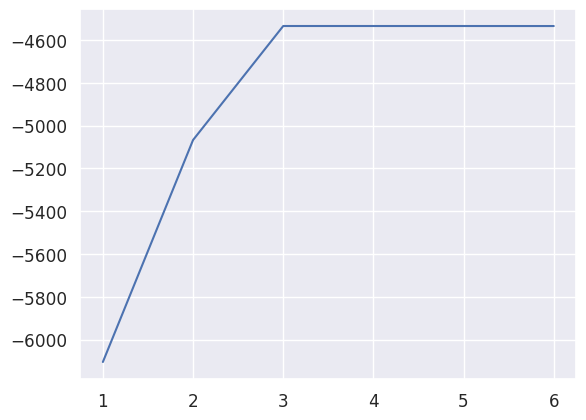

: 

In [ ]:
ks = range(1,int(len(lpds)+1))
ml = jnp.array(lpds)
print(ml.shape)
plt.plot(ks, ml)

### Part 4: Clustering images using the Bayesian Gaussian Mixture Model

The goal of this part is to apply the Bayesian mixture model to cluster images. We will work with the same data as in exercise 7. That is, a subset of images from the Linnaeus 5 dataset (http://chaladze.com/l5/), where we have use a ResNet18 network as feature extractor. See Exercise 7 for more details. The main difference is now that we won't feed the image labels to the algorithm, but only the image features.

First, we load the data and reduce to the dimensionity using PCA.

In [46]:
data = jnp.load('./ex7_data.npz')
labels = list(data['labels'])
print(data.keys())
features = data['features']
targets = data['targets']
num_classes = data['num_classes'][()]

X = PCA_dim_reduction(features, num_components=10)
N, D = X.shape

# split into training/test
key = random.PRNGKey(222)
Ntrain = int(0.8*N)
Ntest = N - Ntrain

idx_train = random.choice(key, jnp.arange(N), shape=(Ntrain,), replace=False)
idx_test = jnp.setdiff1d(jnp.arange(N), idx_train)

print('Number of images: %d' % N)
print('Number of features: %d' % D)

Xtrain, Xtest = X[idx_train], X[idx_test]
ttrain, ttest = targets[idx_train], targets[idx_test]

KeysView(NpzFile './ex7_data.npz' with keys: Xtrain, Xtest, ttrain, ttest, num_classes...)


KeyError: 'features is not a file in the archive'

and let's visualize some examples.

In [ ]:
def show_example(ax, i, title=True):
    img = Image.open('./images/%d.jpg' % i)
    target = targets[i]
    label = labels[int(target)]
    ax.imshow(img)
    if title:
        ax.set_title(label)
    ax.grid(False)
    ax.axis('off')

fig, ax_ = plt.subplots(2, 5, figsize=(20, 6))
ax = ax_.flat
for i in range(10):
    show_example(ax[i], i)

Recall that the images come from a dataset containing the following four labels: berry, flower, dog, bird. 
Let's fit a Bayesian GMM with $K = 4$ to the training set and inspect images from the identified components. 


In [ ]:
vi = VariationalGMM(D=D, K=4, alpha0=1e-3).fit(Xtrain.squeeze(), max_itt=10000, verbose=True)

Let's plot the posterior mean of the mixing weights

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.bar(jnp.arange(1, vi.K+1), vi.pi)
ax.set(xlabel='Component index', ylabel='Posterior mean for $\\pi_k$', title='Posterior mean of mixing weights', xticks=jnp.linspace(1, vi.K, min(vi.K, 20)).round());

The code below visualizes images from some of the larger clusters (containing 30 images or more)

**Task 4.8**: Does the four clusters align with the target labels of the data set? [**Discussion question**]

**Task 4.9**: Increase the number of clusters to $K = 50$ and repeat the analysis. Can you spot any patterns representative for each cluster?  [**Discussion question**]

- Note: We allow for a maximum of 10000 iterations, but it should converge much earlier.




In [ ]:
def visualize_img_clustering(z, K, idx_list):
    
    for k in range(K):
        
        # find and count all images assigned to cluster k
        idx_k = jnp.where(z == k)[0]
        
        num_images_in_cluster = len(idx_k)
        
        if num_images_in_cluster < 30:
            continue

        # visualiz
        fig, axes = plt.subplots(3, 5, figsize=(20, 12.5))

        for idx_plot, idx in enumerate(idx_k):
            if idx_plot >= jnp.prod(jnp.array(axes.shape)):
                break

            show_example(axes.flat[idx_plot], idx_list[idx], False)

        fig.subplots_adjust(hspace=0.0, wspace=0.00)
        fig.suptitle('Cluster idx %d with %d images' % (k+1, num_images_in_cluster), fontweight='bold')


ptrain = vi.compute_component_probs(Xtrain)
ztrain = jnp.argmax(ptrain, axis=1)
visualize_img_clustering(ztrain, vi.K, idx_train)